In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer

import joblib


In [38]:
# Load dataset
df = pd.read_csv("bank_transactions_data_edited.csv")

In [39]:
# Tampilkan 5 baris pertama
df.head()


,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70.0,Doctor,81.0,1.0,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68.0,Doctor,141.0,1.0,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19.0,Student,56.0,1.0,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26.0,Student,25.0,1.0,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,NaN,Student,198.0,1.0,7429.40,2024-11-04 08:06:39


In [40]:
# Informasi dataset
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2537 entries, 0 to 2536
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2508 non-null   object 
 1   AccountID                2516 non-null   object 
 2   TransactionAmount        2511 non-null   float64
 3   TransactionDate          2509 non-null   object 
 4   TransactionType          2507 non-null   object 
 5   Location                 2507 non-null   object 
 6   DeviceID                 2507 non-null   object 
 7   IP Address               2517 non-null   object 
 8   MerchantID               2514 non-null   object 
 9   Channel                  2510 non-null   object 
 10  CustomerAge              2519 non-null   float64
 11  CustomerOccupation       2514 non-null   object 
 12  TransactionDuration      2511 non-null   float64
 13  LoginAttempts            2516 non-null   float64
 14  AccountBalance          

In [41]:
# Statistik deskriptif
df.describe()


,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,2511.000000,2519.000000,2511.000000,2516.000000,2510.000000
mean,297.656468,44.678444,119.422939,1.121622,5113.438124
std,292.230367,17.837359,70.078513,0.594469,3897.975861
min,0.260000,18.000000,10.000000,1.000000,101.250000
25%,81.310000,27.000000,63.000000,1.000000,1504.727500
50%,211.360000,45.000000,112.000000,1.000000,4734.110000
75%,413.105000,59.000000,161.000000,1.000000,7672.687500
max,1919.110000,80.000000,300.000000,5.000000,14977.990000


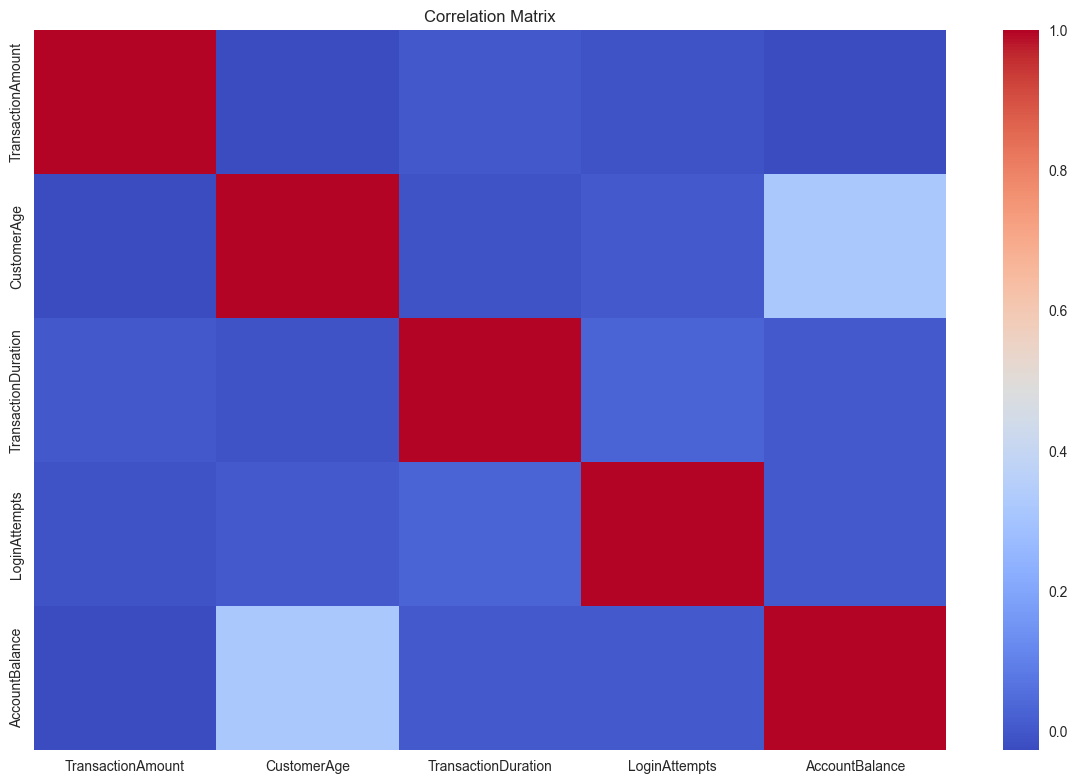

In [42]:
# Korelasi antar fitur numerik
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


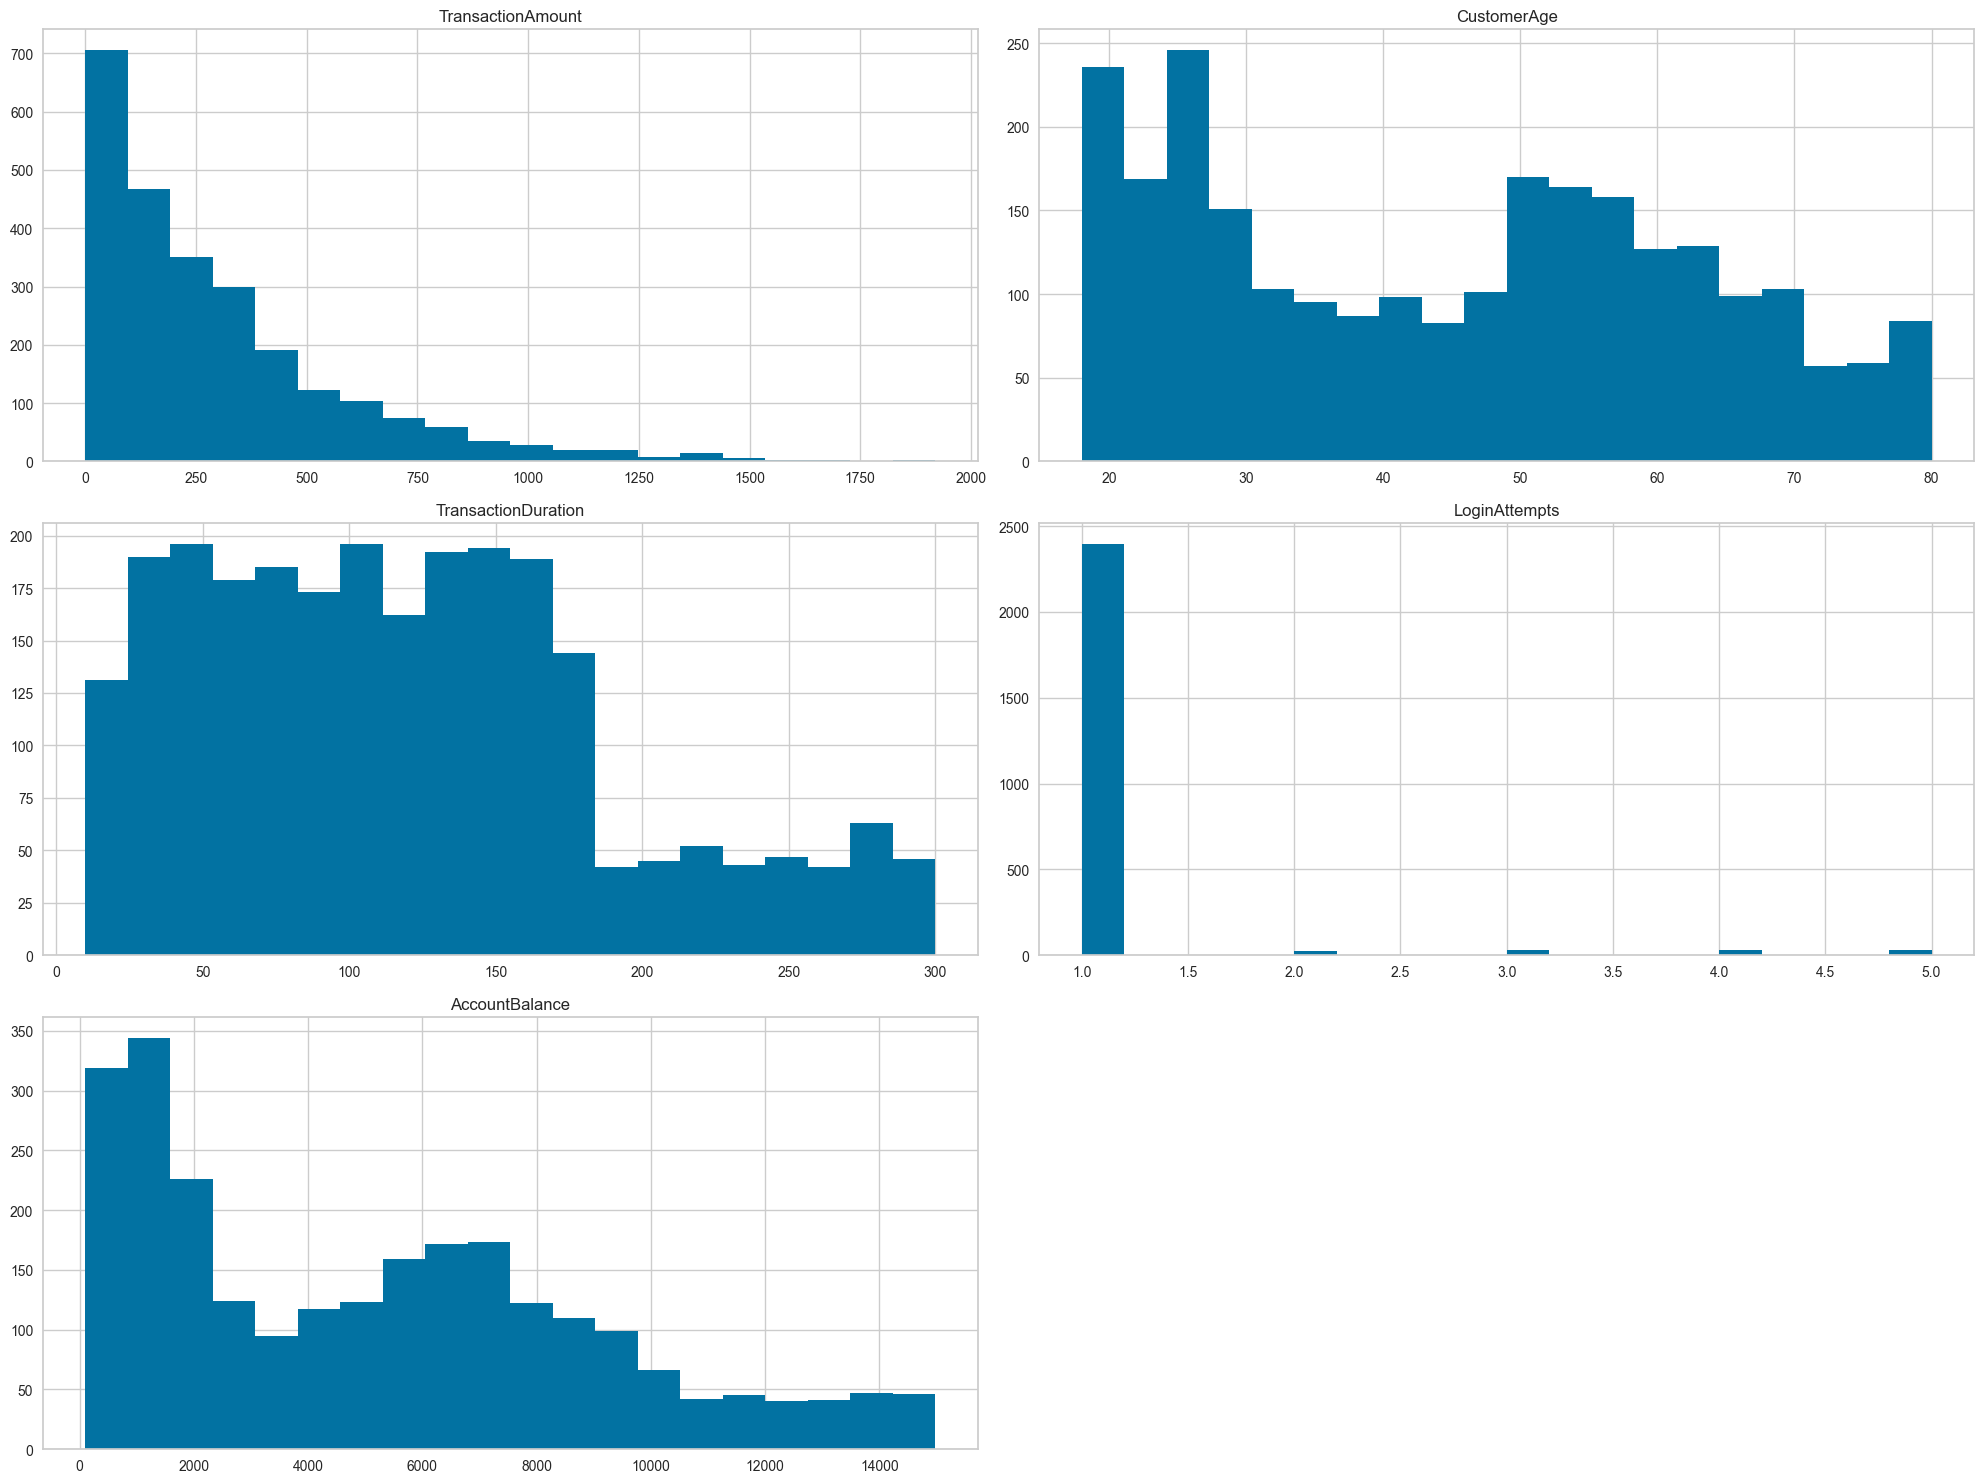

In [43]:
# Histogram untuk semua kolom numerik
df.select_dtypes(include=['int64', 'float64']).hist(figsize=(20, 15), bins=20)
plt.tight_layout()
plt.show()


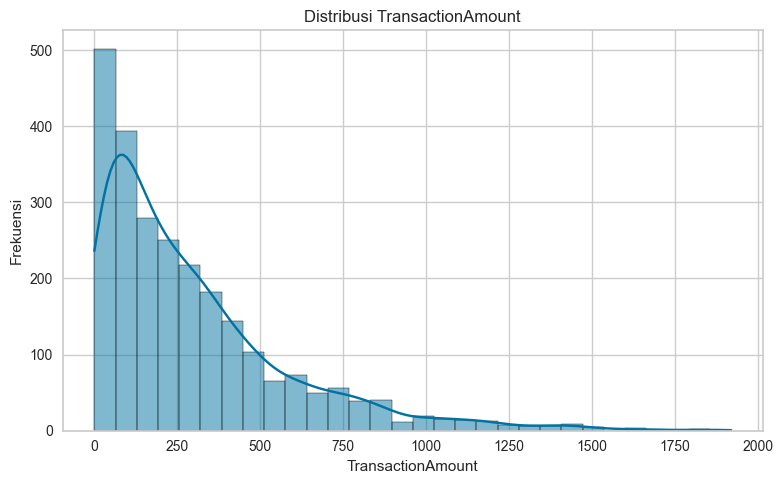

In [44]:
# Distribusi TransactionAmount
plt.figure(figsize=(8, 5))
sns.histplot(df['TransactionAmount'], bins=30, kde=True)
plt.title("Distribusi TransactionAmount")
plt.xlabel("TransactionAmount")
plt.ylabel("Frekuensi")
plt.tight_layout()
plt.show()


In [45]:
# Cek missing value
df.isnull().sum()


TransactionID              29
AccountID                  21
TransactionAmount          26
TransactionDate            28
TransactionType            30
Location                   30
DeviceID                   30
IP Address                 20
MerchantID                 23
Channel                    27
CustomerAge                18
CustomerOccupation         23
TransactionDuration        26
LoginAttempts              21
AccountBalance             27
PreviousTransactionDate    24
dtype: int64

In [46]:
# Cek data duplikat
df.duplicated().sum()


np.int64(21)

In [47]:
# Hapus baris dengan nilai kosong
df = df.dropna()

# Hapus data duplikat
df = df.drop_duplicates()


In [48]:
# Drop kolom ID, Date, dan IP Address
df = df.drop(columns=[
    'TransactionID',
    'AccountID',
    'DeviceID',
    'IPAddress',
    'TransactionDate'
], errors='ignore')


In [49]:
# Encoding fitur kategorikal
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [50]:
# Cek seluruh fitur setelah encoding
df.columns.tolist()


['TransactionAmount',
 'TransactionType',
 'Location',
 'IP Address',
 'MerchantID',
 'Channel',
 'CustomerAge',
 'CustomerOccupation',
 'TransactionDuration',
 'LoginAttempts',
 'AccountBalance',
 'PreviousTransactionDate']

In [51]:
# Handling outlier menggunakan IQR
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]


In [52]:
# Scaling fitur numerik
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[numeric_columns] = scaler.fit_transform(df_scaled[numeric_columns])


In [53]:
# Binning TransactionAmount
df_scaled['TransactionAmount_Bin'] = pd.cut(
    df_scaled['TransactionAmount'],
    bins=3,
    labels=['Low', 'Medium', 'High']
)

# Encode hasil binning
le_bin = LabelEncoder()
df_scaled['TransactionAmount_Bin'] = le_bin.fit_transform(
    df_scaled['TransactionAmount_Bin']
)


In [54]:
# Statistik deskriptif setelah preprocessing
df_scaled.describe()


,TransactionAmount,TransactionType,Location,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,TransactionAmount_Bin
count,1.501000e+03,1501.0,1.501000e+03,1.501000e+03,1.501000e+03,1501.000000,1.501000e+03,1.501000e+03,1.501000e+03,1501.0,1.501000e+03,1.501000e+03,1501.000000
mean,-4.733796e-17,0.0,-8.520832e-17,2.189381e-17,-8.047453e-17,0.000000,4.733796e-18,-5.798900e-17,-1.183449e-18,0.0,2.781105e-16,-5.207175e-17,1.144570
std,1.000333e+00,0.0,1.000333e+00,1.000333e+00,1.000333e+00,1.000333,1.000333e+00,1.000333e+00,1.000333e+00,0.0,1.000333e+00,1.000333e+00,0.560731
min,-1.172368e+00,0.0,-1.720664e+00,-1.777358e+00,-1.701679e+00,-1.088615,-1.486636e+00,-1.316889e+00,-1.534919e+00,0.0,-1.283047e+00,-1.761603e+00,0.000000
25%,-8.072665e-01,0.0,-9.091267e-01,-8.510418e-01,-8.788983e-01,-1.088615,-9.793367e-01,-1.316889e+00,-7.906613e-01,0.0,-9.337901e-01,-8.489350e-01,1.000000
50%,-2.725665e-01,0.0,-1.643619e-02,-2.159560e-02,4.673023e-02,0.136281,-2.110461e-02,-4.407141e-01,-1.025737e-01,0.0,-1.034678e-01,4.851244e-03,1.000000
75%,5.277131e-01,0.0,8.762543e-01,8.744484e-01,8.695111e-01,1.361177,8.243943e-01,1.311635e+00,6.135991e-01,0.0,6.647565e-01,8.488238e-01,1.000000
max,3.034644e+00,0.0,1.687791e+00,1.764438e+00,1.692292e+00,1.361177,2.008093e+00,1.311635e+00,2.537436e+00,0.0,2.568818e+00,1.761492e+00,2.000000


c:\Users\asus\Documents\GitHub\dicoding-machine-learning-project\venv\Lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\Users\asus\Documents\GitHub\dicoding-machine-learning-project\venv\Lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


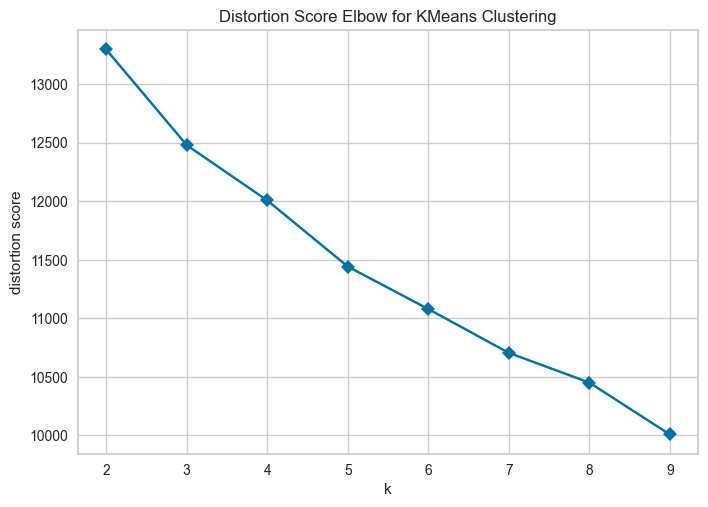

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
# Elbow Method untuk menentukan jumlah cluster optimal
kmeans_model = KMeans(random_state=42)

visualizer = KElbowVisualizer(
    kmeans_model,
    k=(2, 10),
    metric='distortion',
    timings=False
)

visualizer.fit(df_scaled)
visualizer.show()


In [56]:
# Tentukan jumlah cluster optimal
k_optimal = 4  # ganti jika hasil elbow berbeda

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)


Berdasarkan visualisasi Elbow Method, penurunan nilai distortion mulai melandai pada k = 4.
Oleh karena itu, jumlah cluster optimal yang digunakan adalah 4.


In [57]:
joblib.dump(kmeans, "model_clustering.h5")

['model_clustering.h5']

In [58]:
sil_score = silhouette_score(df_scaled, cluster_labels)
print(f"Silhouette Score: {sil_score:.4f}")


Silhouette Score: 0.0873


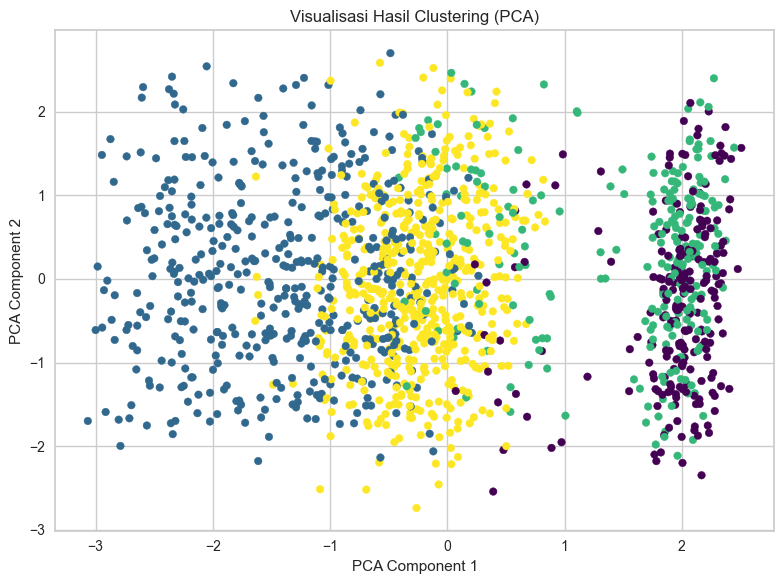

In [59]:
# PCA untuk visualisasi
pca = PCA(n_components=2, random_state=42)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=cluster_labels, cmap='viridis', s=30)
plt.title("Visualisasi Hasil Clustering (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [60]:
joblib.dump(pca, "PCA_model_clustering.h5")


['PCA_model_clustering.h5']

In [61]:
# Tambahkan label cluster ke data hasil preprocessing
df_scaled['Target'] = cluster_labels

In [62]:
# Analisis statistik per cluster (data scaled)
cluster_summary = df_scaled.groupby('Target').agg(['mean', 'min', 'max'])
cluster_summary


TransactionAmount                     TransactionType            \
                    mean       min       max            mean  min  max   
Target                                                                   
0              -0.000819 -1.169573  2.857497             0.0  0.0  0.0   
1              -0.065019 -1.172089  3.004824             0.0  0.0  0.0   
2               0.101396 -1.172368  3.034644             0.0  0.0  0.0   
3               0.011612 -1.169666  2.966525             0.0  0.0  0.0   

        Location                     IP Address  ... LoginAttempts  \
            mean       min       max       mean  ...           max   
Target                                           ...                 
0      -0.790462 -1.720664  1.282023   0.223108  ...           0.0   
1      -0.018813 -1.720664  1.687791   0.016491  ...           0.0   
2       0.888510 -1.071434  1.687791  -0.046604  ...           0.0   
3      -0.055766 -1.720664  1.687791  -0.084383  ...           0.0   

       AccountBalance                     PreviousTransactionDate            \
                 mean       min       max                    mean       min   
Target                                                                        
0           -0.935777 -1.278961  1.097940                0.181584 -1.751789   
1            1.129870 -0.151798  2.568818               -0.020258 -1.761603   
2           -0.748408 -1.283047  1.206480               -0.328131 -1.761603   
3           -0.264319 -1.280313  0.761117                0.089004 -1.761603   

                 TransactionAmount_Bin          
             max                  mean min max  
Target                                          
0       1.751678              1.053333   0   2  
1       1.751678              1.179916   0   2  
2       1.712424              1.118367   0   2  
3       1.761492              1.162749   0   2  

[4 rows x 39 columns]

In [63]:
# Simpan data clustering (scaled + Target)
df_scaled.to_csv("data_clustering.csv", index=False)


In [64]:
# Inverse scaling untuk fitur numerik
df_inverse = df_scaled.copy()
df_inverse[numeric_columns] = scaler.inverse_transform(df_scaled[numeric_columns])


In [65]:
# Inverse encoding untuk fitur kategorikal
for col, le in label_encoders.items():
    df_inverse[col] = le.inverse_transform(df_inverse[col].astype(int))


In [66]:
# Analisis deskriptif numerik setelah inverse
numeric_cols = df_inverse.select_dtypes(include=['int64', 'float64']).columns

cluster_summary_numeric = (
    df_inverse
    .groupby('Target')[numeric_cols]
    .agg(['mean', 'min', 'max'])
)

cluster_summary_numeric


TransactionAmount               CustomerAge              \
                    mean   min     max        mean   min   max   
Target                                                           
0             251.703733  0.86  865.17   23.408889  18.0  38.0   
1             237.924916  0.32  896.79   46.265690  26.0  70.0   
2             273.641755  0.26  903.19   25.914286  18.0  54.0   
3             254.371736  0.84  888.57   59.448463  29.0  80.0   

       TransactionDuration              LoginAttempts            \
                      mean   min    max          mean  min  max   
Target                                                            
0               142.071111  13.0  299.0           1.0  1.0  1.0   
1               122.186192  10.0  300.0           1.0  1.0  1.0   
2                94.093878  11.0  295.0           1.0  1.0  1.0   
3               118.719711  10.0  298.0           1.0  1.0  1.0   

       AccountBalance                    TransactionAmount_Bin          
                 mean      min       max                  mean min max  
Target                                                                  
0         1443.346489   117.98   9297.50              1.053333   0   2  
1         9420.815251  4471.05  14977.99              1.179916   0   2  
2         2166.961184   102.20   9716.68              1.118367   0   2  
3         4036.498770   112.76   7996.70              1.162749   0   2

In [67]:
## Cek Data Inverse
df_inverse.head()

,TransactionAmount,TransactionType,Location,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,TransactionAmount_Bin,Target
0,14.09,Debit,San Diego,162.198.218.92,M015,ATM,70.0,Doctor,81.0,1.0,5112.21,2024-11-04 08:08:08,1,3
1,376.24,Debit,Houston,13.149.61.4,M052,ATM,68.0,Doctor,141.0,1.0,13758.91,2024-11-04 08:09:35,2,1
2,126.29,Debit,Mesa,215.97.143.157,M009,Online,19.0,Student,56.0,1.0,1122.35,2024-11-04 08:07:04,1,2
3,184.50,Debit,Raleigh,200.13.225.150,M002,Online,26.0,Student,25.0,1.0,8569.06,2024-11-04 08:09:06,1,2
5,92.15,Debit,Oklahoma City,117.67.192.211,M054,ATM,18.0,Student,172.0,1.0,781.68,2024-11-04 08:06:36,1,2


In [68]:
# Simpan data inverse + Target
df_inverse.to_csv("data_clustering_inverse.csv", index=False)


### a. Interpretasi Hasil Clustering

Berdasarkan analisis deskriptif pada data yang telah dikembalikan ke skala aslinya (inverse transform),
diperoleh karakteristik masing-masing cluster sebagai berikut:

**Cluster 0**
- Memiliki rata-rata TransactionAmount paling tinggi dibandingkan cluster lain.
- AccountBalance rata-rata berada pada kisaran menengah.
- Mengindikasikan pengguna dengan aktivitas transaksi tinggi.

**Cluster 1**
- TransactionAmount rata-rata lebih rendah dibandingkan Cluster 0.
- AccountBalance rata-rata paling tinggi.
- Mencerminkan pengguna yang stabil dan cenderung berhati-hati dalam bertransaksi.

**Cluster 2**
- TransactionAmount rata-rata berada pada tingkat menengah.
- AccountBalance rata-rata berada pada kisaran menengah.
- Dapat dikategorikan sebagai pengguna reguler.

**Cluster 3**
- Memiliki TransactionAmount dan AccountBalance rata-rata paling rendah.
- Mengindikasikan pengguna dengan aktivitas transaksi rendah.